# Simulation

In [1]:
############
###import###
############
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec
#######################
###parameter setting###
#######################

## simulation parameters

# scalars
GLOBALPARAMS = Namespace()

duration=1500 #Duration of a single run in ms.
dt=0.1 # Simulation time step in ms.
NRuns=100 #Number of consecutive runs in one simulation.
stopnow=0
noisetau=50 # Filter time for the input in ms
Backgroundrate=5*dt/1000 # Background spiking probability 5Hz*dt (= 0.0005) (see Technical Appendix 6.2.1).
ApproximateNormalizingFactor=0.03 # This serves to normalize the trace to an approximate peak value of 1
Maxrate=500*dt/1000 # Peak spiking probability 500Hz*dt (= 0.05))
NSigs=8 # Number of input signals.
NCells=1000 # Number of input spike trains.
ExFrac=0.8 #Fraction of Excitatory spike trains.
ExGroupsize=(NCells*ExFrac)/NSigs # Number of spike trains in each excitatory input group. =100
InGroupsize = math.ceil((NCells*(1-ExFrac))/NSigs) # Number of spike trains in each inhibitory input group. =25

# vectors
Input=np.zeros(NSigs) # A vector that holds the momentary input signal for each signal channel
Timevector=np.arange(0.1,duration+0.1,dt) # A vector of time in ms, in steps of dt.
Exkeep=Timevector*0
Inkeep=Timevector*0 # Vectors to keep the synaptic currents.
FilteredWhiteNoise=np.zeros(8) # A vector to create the time-filtered input
InputGroup=np.zeros(NCells) # A Vector that keeps track of which spike train belongs to which input
InputSpikeRefr=np.zeros(NCells) # To keep track of the input spike train refractory periods)

GLOBALPARAMS.Synapse=np.ones(NCells) #Synaptic weights
GLOBALPARAMS.sgEx=np.zeros(NSigs)
GLOBALPARAMS.sgIn=np.zeros(NSigs) # Vectors to save the group-wise synaptic conductances the cell experiences.
GLOBALPARAMS.AveExCurr=np.zeros(NSigs)
GLOBALPARAMS.AveInCurr=np.zeros(NSigs) # Vectors to save the group-wise synaptic currents the cell experiences.
pre=np.zeros(NCells) # A Vector to save the presynaptic learning trace.
Time=np.arange(NRuns)
Rate=np.zeros(NRuns) #Vectors for plotting


## inhibitory plasticity related parameters
eta=0.001 #Learning Rate
alpha=0.25*eta #Depression Factor * Learning Rate
tauPlasticity=20 #Time window of the learning rule.
gBarEx=0.014 # Scaling factor of the excitatory synaptic conductance in units of the leak (gleak = 10 nS)
gBarIn=0.035 # Scaling factor of the inhibitory synaptic conductance in units of the leak (gleak = 10 nS)
tauEx=5 # Excitatory synaptic time constant, in ms.
tauIn=10 # Inhibitory synaptic time constant, in ms.

## neuron related parameters
tRef=5 # Refractory period for the spike trains.
VRest=-60 #Resting potential in mV.
Vth=-50 # Threshold, in mV.
taumem=20 # Membrane time constant, in ms.
EAMPA=0 # Excitatory reversal potential, in mV.
EGABA=-80 # Inhibitory reversal potential, in mV.


## Pre-calculated exponential factors for speed of simulation
expGEx=np.exp(-dt/tauEx)
expGIn=np.exp(-dt/tauIn)
expPlasticity=np.exp(-dt/tauPlasticity)
expnoise=np.exp(-dt/noisetau)

### assign group number to 1000 cells

In [2]:
## InputGroups
# pre synaptic excitatory neuron 1-100 : 1
#                     101-200 : 2
#                     701-800 : 8
# pre synaptic inhibitory neuron: 801-825 : -8
#                                 826-850 : -7
#                                 ...
#                                 976-1000 : -1

InputGroup[0:100] = 1
InputGroup[100:200] = 2
InputGroup[200:300] = 3
InputGroup[300:400] = 4
InputGroup[400:500] = 5
InputGroup[500:600] = 6
InputGroup[600:700] = 7
InputGroup[700:800] = 8

InputGroup[800:825] = -8
InputGroup[825:850] = -7
InputGroup[850:875] = -6
InputGroup[875:900] = -5
InputGroup[900:925] = -4
InputGroup[925:950] = -3
InputGroup[950:975] = -2
InputGroup[975:1000] = -1


## Synapse Tuning
for i in range(800):
    GLOBALPARAMS.Synapse[i] = 0.3 + (1.1/(1+(InputGroup[i]-5)**4))+np.random.rand()*0.1

for i in range(801,NCells):
    GLOBALPARAMS.Synapse[i] = 0.1

# This routine assigns a synaptic weight to every synapse. Excitatory synapses are tuned
#according to their group identity (plus a noise term) to resemble the tuning reported in (7).
#Inhibitory synapses are uniformly weak.

In [3]:
## plot functions

def synaptic_currents(axis,Timevector,Exkeep,Inkeep,duration):

    # to pA
    axis.plot(Timevector, Exkeep/100,'k', linewidth= 1)
    # plotting in units of nA hence the values need to be divided by 100, see above.
        
    axis.plot(Timevector,Inkeep/100,c= [0.6 ,0.6, 0.6], linewidth= 1)
    axis.plot(Timevector,(Inkeep+Exkeep)/100,c= [0, 0.6, 0])
    axis.set_ylabel('Synaptic Currents [nA]')
    # set axis limits
    axis.set_xlim([0, duration])
    axis.set_ylim([-3, 3])
    axis.legend(['Ex.','Inh.','Net'])
    return axis

def mem_pot(axis,stopnow,Timevector,V,duration):
    if (stopnow==0):
        axis.plot(Timevector, V, 'k')
        axis.set_ylabel('Mem. Pot. [mV]')
        axis.set_xlabel('Time [ms]')
        # set axis limits
        axis.set_xlim([0, duration])
        axis.set_ylim([-65, 5])
        
    return axis 

def mean_synaptic_strength_and_synaptic_strength(axis,Time,Rate,runcount,NRuns,duration,synaptic_strength_x,synaptic_strength_y1,synaptic_strength_y2,synaptic_strength_y3):
    # there are two y-axis on this graph
    # drawing the y-axis on the left second
    axis.plot(Time[0:runcount], Rate[0:runcount], '.-k')

    axis.set_ylabel('Mean Output Rate [Hz]')
    axis.set_ylim([0, 100])

    axis.set_xlabel('Time [min]')
    axis.set_xlim([0, NRuns*duration/1000])
    axis.xaxis.set_major_formatter(lambda x,pos: "{:.2}".format(x/60))
    axis2 = axis.twinx()
    
    # added arrays outside of the loop
    # in matlab the points were added to the plot
    # in python the plot is overwritten - we soo only the latest data
    # mitigation strategy = use lists to collect points over time
    synaptic_strength_x.append(runcount*duration/1000)
    synaptic_strength_y1.append(np.mean(GLOBALPARAMS.Synapse[924:949])*gBarIn*10000)
    synaptic_strength_y2.append(np.mean(GLOBALPARAMS.Synapse[899:924])*gBarIn*10000)
    synaptic_strength_y3.append(np.mean(GLOBALPARAMS.Synapse[874:899])*gBarIn*10000)

    # drawing the y-axis on the right first
    axis2.plot(synaptic_strength_x, synaptic_strength_y1, '.', c='r')
    # (Plotted in units of pS)
    axis2.plot(synaptic_strength_x, synaptic_strength_y2, '.', c=[0.5, 0.0, 0.5])
    # (Plotted in units of pS)
    axis2.plot(synaptic_strength_x, synaptic_strength_y3,  '.', c='b')
    # (Plotted in units of pS)
    axis2.set_ylabel('Mean Synaptic Strength [pS]')
    # set axis limits
    axis2.set_ylim([0, 800])
    axis2.legend(['S3','S4','S5'])
    return axis

def mean_synaptic_currents(axis,AveExCurr,AveInCurr,AveCurrCounter):
    x = list(range(1,9))
    y1 = 10*(-AveExCurr/AveCurrCounter)
    y2 = 10*(AveInCurr/AveCurrCounter)

    axis.plot(x, y1,'-ks',linewidth=2,\
        markeredgecolor='k',\
        markerfacecolor='k',\
        markersize=10)

    axis.plot(x, y2,'-ks',linewidth=2,\
        markeredgecolor='k',\
        markerfacecolor='w',\
        markersize=10)
    
    # set axis limits
    axis.set_xlabel('Signal Number')
    axis.set_ylabel('Mean Synaptic Currents [pA]')
    axis.legend(['Ex','In'])
    axis.set_xlim([1, 8])
    axis.set_ylim([0, 270])

    return axis

In [4]:
class LIFNeuron(object):
    """Our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 20, v_reset = 0, v_th = -50, I_b = 0, dt = 0.1,
                ):
        super(LIFNeuron, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.v_rest = -60 # leak reversal potential
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_b = I_b # Input current
        self.dt = dt # simulation timestep    
        self.gLeak = 1
        self.tolos = 0 #(== t(ime)o(f)l(ast)(o)utput (s)pike (Keeping track of the output cell's refractory period )

        ### Initiate the recording lists
        self.V = np.zeros(len(Timevector)) 
        self.V[0]=self.v_rest

        self.post=0 # Postsynaptic learning trace.
        self.t_list = Timevector
        
        
        ### Initiate synaptic paramters
        self.V_E = 0
        self.V_I = -80
        
    def update_trace(self):
        self.post = self.post*expPlasticity

        
    def timestep(self,tRunning,t,gEx,gIn):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''

        ### Time evolution of the synaptic input
        
        ## Membrane potential and postsynaptic spikes.
        if ((tRunning - self.tolos) < tRef):
            self.V[t] = self.v_rest
            # If the Cell is refractory, keep V at Vrest
        else:
            # Meaning: if the cell is not refractory, ...
            gTot = self.gLeak + gEx + gIn
            # calculate the total membrane conductance,
            tauEff=taumem/gTot
            # and the effective time constant, as well as...
            VInf = ((self.gLeak*self.v_rest + gEx * self.V_E+ gIn*self.V_I)/gTot)
            # the membrane potential that V strives towards.
            self.V[t] = VInf + (self.V[t-1] - VInf)*np.exp(-dt/tauEff)
            # Use the above to update the membrane potential

            GLOBALPARAMS.AveExCurr = GLOBALPARAMS.AveExCurr + GLOBALPARAMS.sgEx*(self.V[t]-self.V_E)
            GLOBALPARAMS.AveInCurr = GLOBALPARAMS.AveInCurr +  GLOBALPARAMS.sgIn*(self.V[t]-self.V_I) + (self.gLeak*(self.V[t]-self.v_rest))/NSigs
            
            GLOBALPARAMS.AveCurrCounter=GLOBALPARAMS.AveCurrCounter+1
            # The above routine keeps track for the group-wise input currents for plotting but
            # does not affect the behavior of the cell. We divide the (mostly inhibitory acting)
            # leak current evenly to all Groups,since each input signal causes the same absolute
            # amount of leak current (by deflecting the membrane potential away from rest with
            # identical statistics over time for each signal).
        
    
            
        ### Time evolution of the membrane potential


        if (self.V[t]>self.v_th):
            # If the membrane potential hits threshold...
            self.tolos=tRunning
            # ... set the refractory counter to the current time step
            self.V[t-1]=0
            # ... set the last membrane potential before the spike to zero (for plotting)
            self.V[t]=VRest
            # ... reset the current membrane potential to Vrest.
            GLOBALPARAMS.OutputSpikeCount+=1
            # ... count the spike.
            self.post = self.post + eta
            # ... update the postsynaptic learning trace
            GLOBALPARAMS.Synapse[800:] += pre[800:] 
            
            # update all synapses according to the rule
            # → Add the effect of proximate presynaptic spikes.
                        
        
    

# Spike Train Calculation

Below 2 funtions are defined `create_poisson_process`, from notebook Num. 5, and `create_poisson_process_adapted`, which is an adaptation of the spike train generation in the math lab code.

Output for both is an array of 1s and 0s, where 1 is a spike in a giveng time period.

In [5]:
# defining a function we use later that was already introduced 
# in the last lecture 
def transform_to_event_input(binned_spikes, bin_size=0.1):
    ''' transform binned_spike [spike train arrays, like np.array([0,0,0,1,0,0,1,0,1]) ]
        given the size of the bin bin_size 
        to arrays that cotain the spike times (and are easy to plot with the matplotlib event_plot function )'''
    
    bin_offset = bin_size/2.
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times
    
def create_poisson_process_from_labs(duration, dt, num_signals, rate = 1):
    ''' this function takes an time_steps (an integer) for the lenght of the process
        the rate in Hz (1/s) of the poisson process
        and dt, the bin size (in ms)
        num_signals: A vector that holds the momentary input signal for each signal channel
        rate: is usually given in 1/ms, to match dt dimension
    '''

    time_steps = int(duration / dt)

    rate = rate / 1000
    
    spikes = np.zeros((num_signals, time_steps))
    
    for y in range(time_steps):
        for i in range(num_signals):
          if np.random.rand() < rate * dt:
              spikes[i,y] = 1
    
    return spikes

def create_poisson_process_from_article(duration, dt, num_signals, approx_normalised_factor = 0.03, noisetau = 50):
    """
    duration: Total length of the experiment
    dt: Step of time
    num_signals: A vector that holds the momentary input signal for each signal channel
    approx_normalised_factor: This serves to normalize the trace to an approximate peak value of 1
    noisetau: Filter time for the input in ms
    """
    time_steps = int(duration / dt)
    
    expnoise = np.exp(-dt / noisetau)
    
    # max_rate: Peak spiking probability 500Hz*dt (= 0.05))
    max_rate = 500*dt/1000 

    # background_rate: Background spiking probability 5Hz*dt (= 0.0005) (see Technical Appendix 6.2.1).
    background_rate = 5*dt/1000

    # A vector that holds the momentary input signal for each signal channel
    spikes = np.zeros((num_signals, time_steps)) 

    filtered_white_noise = np.zeros(num_signals)

    for y in range(time_steps):
        for i in range(num_signals):
            #np.random.seed(i)
            re=np.random.rand()-0.5
            filtered_white_noise[i] = re - (re - filtered_white_noise[i]) * expnoise
            prob_spike = background_rate + max(0, max_rate * filtered_white_noise[i]) / approx_normalised_factor
            if np.random.rand() < prob_spike:
              spikes[i,y] = 1

    return spikes

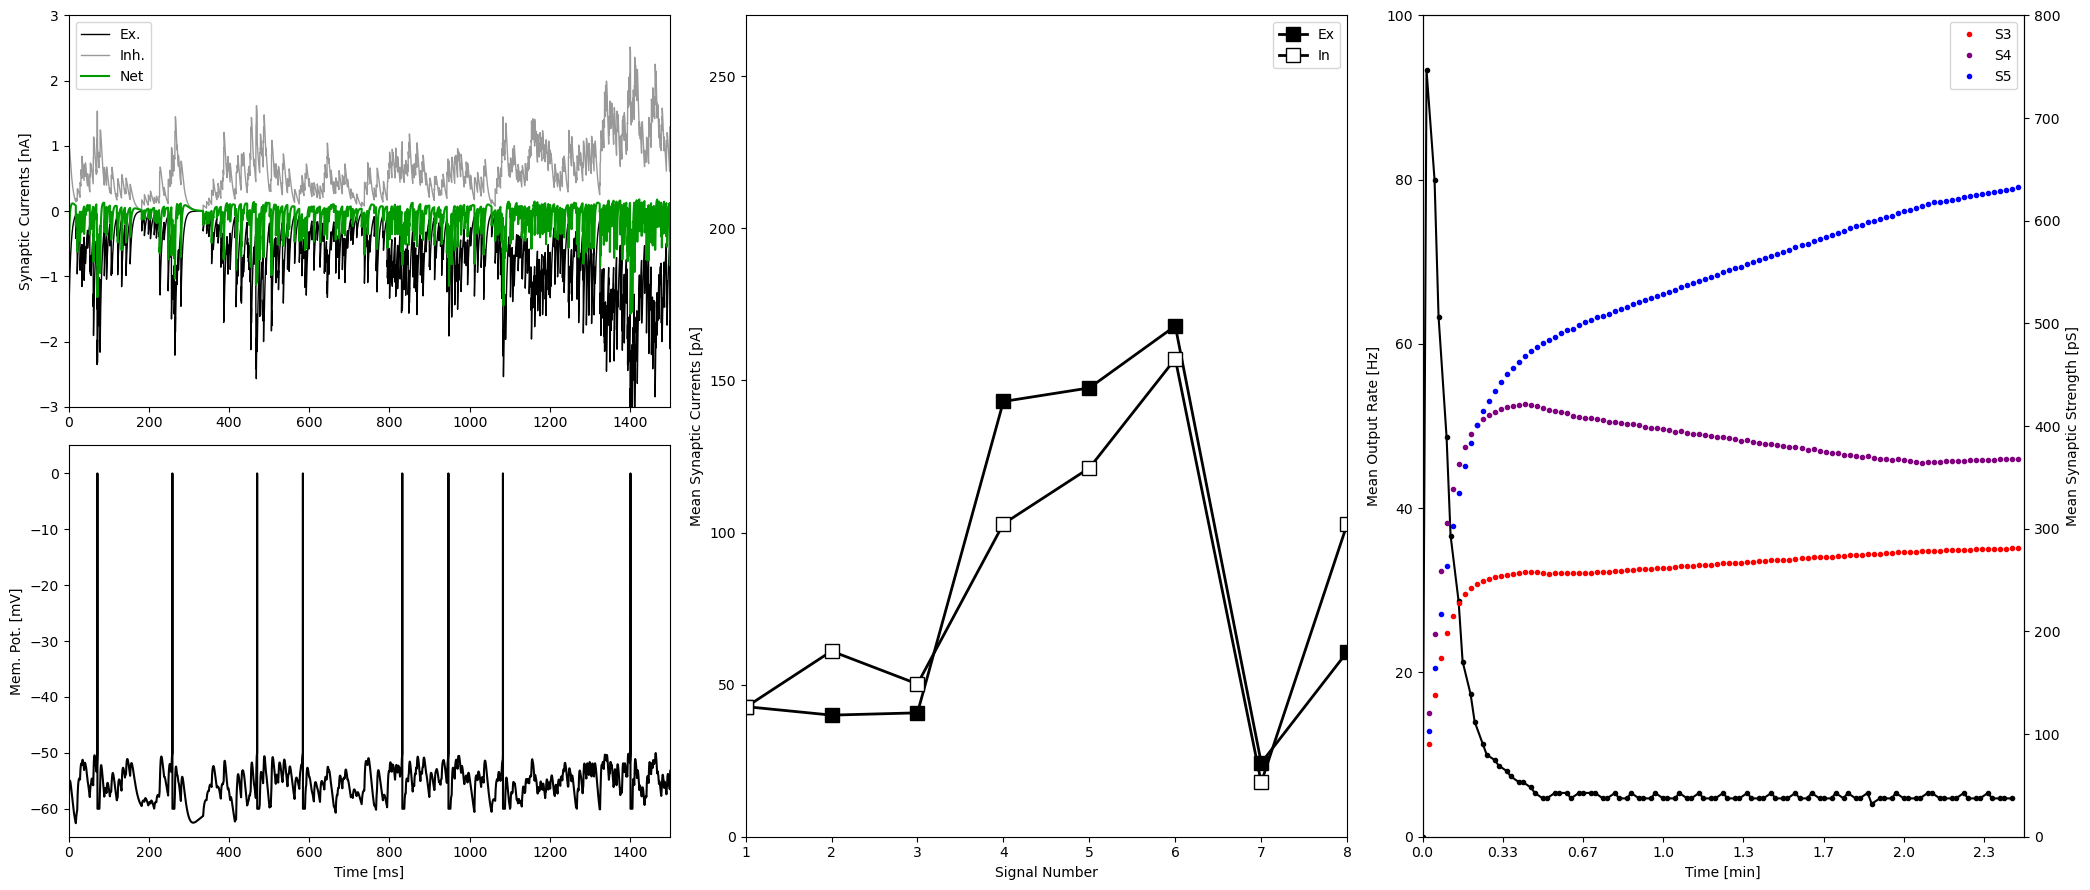

In [6]:

##################
## Simulation#####
##################

## Initialize values
postneuron =  LIFNeuron()
gEx=0 # Overall excitatory synaptic conductance.
gIn=0 # Overall inhibitory synaptic cconductance.

GLOBALPARAMS.InputSpikeCount=0
GLOBALPARAMS.OutputSpikeCount=0
GLOBALPARAMS.AveCurrCounter=0 #Counters for rates and averaging.
tRunning=0
runcount=0
going=1 # Time parameters are initialized

fig = plt.figure(figsize=(21,9), constrained_layout=True)
synaptic_strength_x = []
synaptic_strength_y1 = []
synaptic_strength_y2 = []
synaptic_strength_y3 = []

spikes = create_poisson_process_from_article(duration, dt, NSigs)
# spikes = create_poisson_process_from_labs(duration, dt, NSigs, rate = 40)

## Start of the loops
while going>0:

    if(runcount>=NRuns-1):
        break
    
    runcount=runcount+1
    # A counter to keep track of consecutive runs.

    GLOBALPARAMS.OutputSpikeCount=0
    GLOBALPARAMS.AveExCurr=np.zeros(NSigs)
    GLOBALPARAMS.AveInCurr=np.zeros(NSigs)
    GLOBALPARAMS.AveCurrCounter=0

    for t in np.arange(1,len(Timevector)):
        # The time loop begins here.
        tRunning=tRunning+dt

        gEx = gEx*expGEx
        gIn = gIn*expGIn
        GLOBALPARAMS.sgEx *=expGEx
        GLOBALPARAMS.sgIn *=expGIn
        
        # The synaptic conductances decay exponentially towards 0.
        pre*=expPlasticity
        postneuron.update_trace()
        # The learning traces decay exponentially towards 0.

        ## Presynaptic spike trains

        for i in range(NSigs):
            indexes =  ( np.abs(InputGroup) == (i+1)) & (InputSpikeRefr<=0) 
            exindexes = indexes & (InputGroup>0)
            inindexes = indexes & (InputGroup<0)
            if spikes[i,t]:
                ## update excitatory neurons
                gEx += gBarEx* np.sum(GLOBALPARAMS.Synapse[exindexes])
                GLOBALPARAMS.sgEx[i] += gBarEx* np.sum(GLOBALPARAMS.Synapse[exindexes])
                ## update inhibitory neurons
                gIn += gBarIn* np.sum(GLOBALPARAMS.Synapse[inindexes])
                GLOBALPARAMS.sgIn[i] += gBarIn* np.sum(GLOBALPARAMS.Synapse[inindexes])
                pre[inindexes] += eta

                GLOBALPARAMS.Synapse[inindexes] = GLOBALPARAMS.Synapse[inindexes] + postneuron.post - alpha
                GLOBALPARAMS.Synapse[inindexes] = np.maximum(GLOBALPARAMS.Synapse[inindexes],0)

                InputSpikeRefr[indexes]=tRef
                GLOBALPARAMS.InputSpikeCount+=np.sum(indexes)
            else:
                InputSpikeRefr[np.abs(InputGroup) == (i+1)] -= dt   
       
        postneuron.timestep(tRunning,t,gEx,gIn)

        Exkeep[t]=gEx*(postneuron.V[t]-EAMPA)
        Inkeep[t]=gIn*(postneuron.V[t]-EGABA)
        # For plotting purposes, keeps track of the excitatory and inhibitory synaptic currents.
        # Because everything is normalized by the leak conductance, the values are saved in
        # units of 10nS × mV (= 10−11 Amp = [10pA]).
        # To plot in units of nA, one has to divide this number by 100.
    
    # End of the time loop
    Rate[runcount]=GLOBALPARAMS.OutputSpikeCount/duration*1000
    Time[runcount]=runcount*duration/1000

    ##################
    # Plotting #######
    ##################
    before = 1
    during = 5
    after = 10
    clear_output(wait=True)
    plt.rcParams['figure.figsize'] = (21, 9)
    ax1 = plt.subplot2grid((2, 3), (0,0), colspan = 1, rowspan = 1)
    ax2 = plt.subplot2grid((2, 3), (1,0), colspan = 1, rowspan = 1)
    ax3 = plt.subplot2grid((2, 3), (0,1), colspan = 1, rowspan = 2)
    ax4 = plt.subplot2grid((2, 3), (0,2), colspan = 1, rowspan = 2)
    ax1 = synaptic_currents(ax1,Timevector,Exkeep,Inkeep,duration)
    ax2 = mem_pot(ax2,stopnow,Timevector,postneuron.V,duration)
    ax3 = mean_synaptic_currents(ax3,GLOBALPARAMS.AveExCurr,GLOBALPARAMS.AveInCurr,GLOBALPARAMS.AveCurrCounter)
    ax4 = mean_synaptic_strength_and_synaptic_strength(ax4,Time,Rate,runcount,NRuns,duration,synaptic_strength_x,synaptic_strength_y1,synaptic_strength_y2,synaptic_strength_y3)
    plt.tight_layout()
    plt.show()
    # (This is only ==1 when the EPSP routine is uncommented)
    
# End of the while loop

# Difference of Signal Producing Methods

In [25]:
spike_article = create_poisson_process_from_article(duration, dt, 8, approx_normalised_factor = 0.03, noisetau = 50)
spike_our = create_poisson_process_from_labs(duration, dt, NSigs, rate = 500)
spike_our2 = create_poisson_process_from_labs(duration, dt, NSigs, rate = 40)

print(spike_article.shape)
print(spike_our.shape)

(8, 15000)
(8, 15000)


In [26]:
def plotevent(spike_train,signal_number,title):
    _,event = transform_to_event_input(spike_train[signal_number], bin_size=0.1)
    plt.figure(figsize=(15,3))
    ax = plt.subplot()
    ax.eventplot(event)# just plot the first X entries
    ax.set(
        title = f'Generated Spike Train - {title}',
        xlabel = 'Time in ms',
        ylabel = '',)

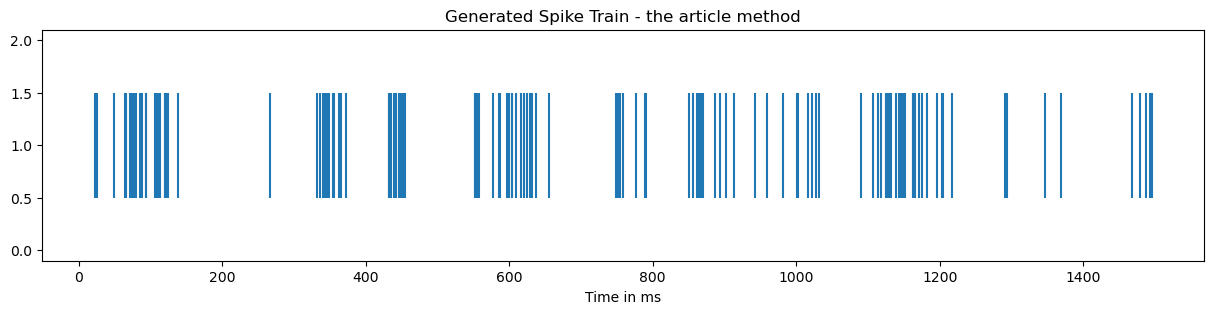

In [27]:
plotevent(spike_article,0,'the article method')

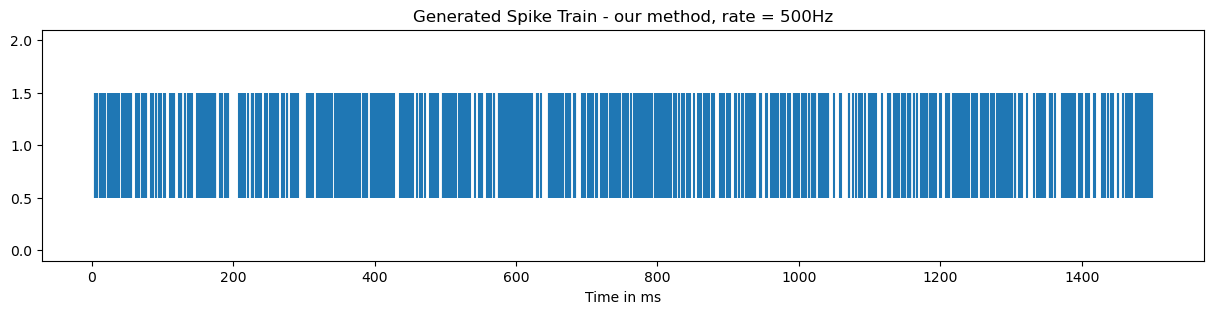

In [28]:
plotevent(spike_our,0,'our method, rate = 500Hz')

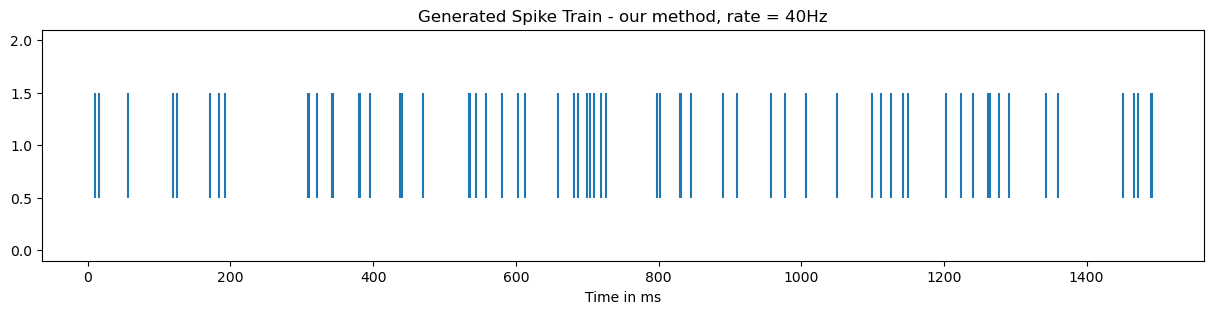

In [29]:
plotevent(spike_our2,0,'our method, rate = 40Hz')

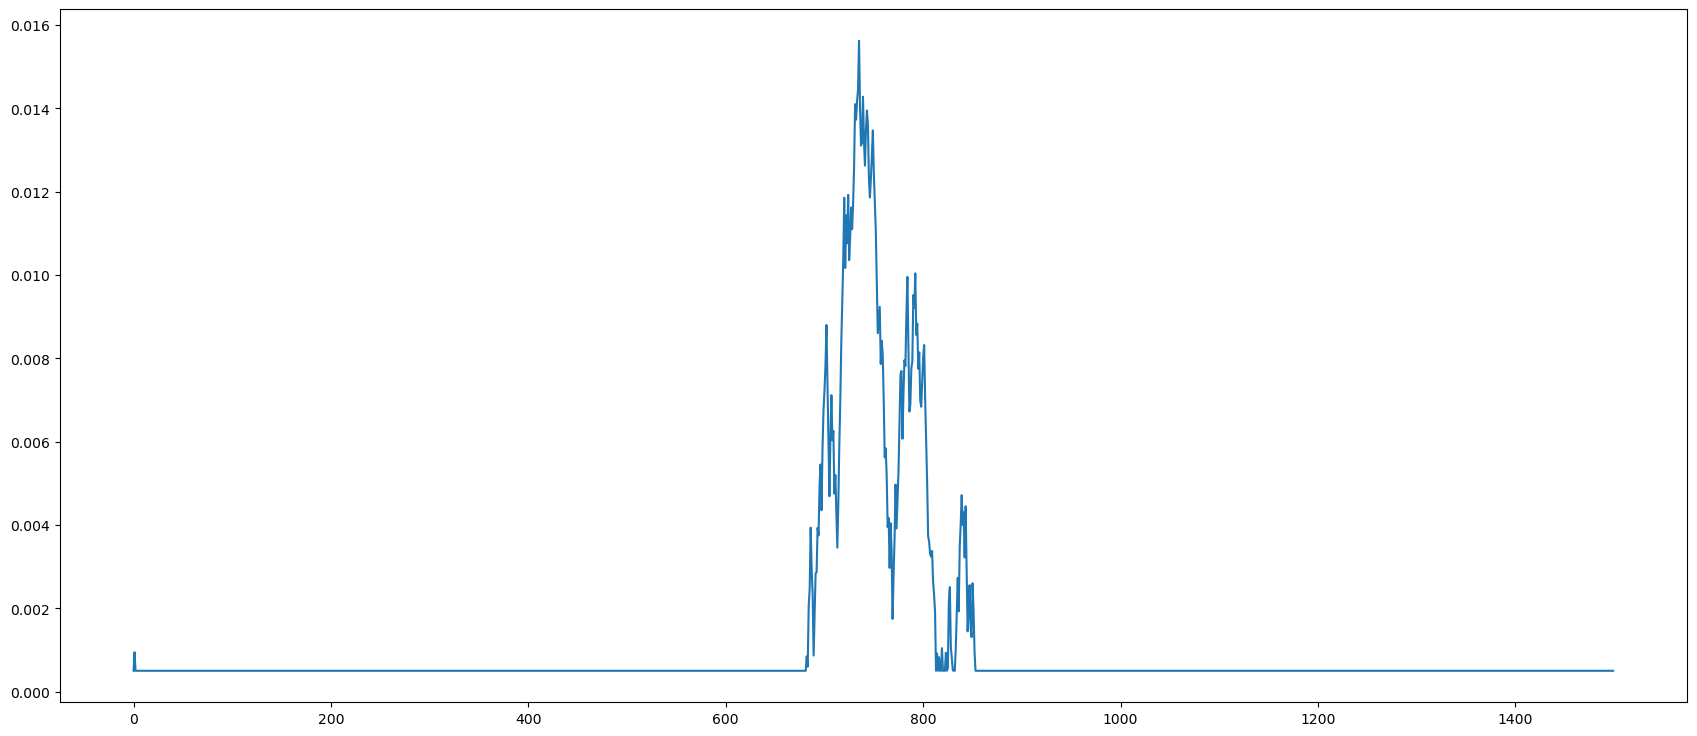

In [30]:

x=0
prob = []
for i in range(1500):
    re=np.random.rand()-0.5
    x = re - (re - x) * expnoise
    prob.append( 0.0005 + max(0, 0.05 * x) / 0.03)

plt.plot(prob)

## what to do next

* animation
* calculate the average firing rate after learning and make fig1G.